In [1]:
import os
import csv
import glob
import random
import numpy as np
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from IPython import display
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

# Utils

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device used: ", device)

Device used:  cuda


In [3]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s ' % checkpoint_path)

# Visualization

In [4]:
def imageshow(image):
    print(image.min(), image.max())
    image *= 255
    # print(image)
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.title(label)
    plt.show()

In [5]:
def batchshow(dataloader):
    """ show the images of a batch of sample """
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.set_xticks([])
        ax.set_yticks([])
        # reshape the img from (3, 32, 32) to (32, 32, 3)
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        plt.show()
        break

# Custom Dataset & DataLoader

In [6]:
class HW2P3(Dataset):
    def __init__(self, dirpath, csv_path, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        # get all image names
        csv_file = open(csv_path)
        csv_reader = csv.reader(csv_file)
        i = 0
        for row in csv_reader:
            if i > 0:
                self.image_paths.append(dirpath + row[0])
                self.labels.append(int(row[1]))
            i += 1
        
    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        if self.transform is not None:
            image = self.transform(image)
        image.unsqueeze(0)

        label = self.labels[index]
        label = torch.tensor(label)
        
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [7]:
mnist_trainset = HW2P3(
    dirpath='./hw2_data/digits/mnistm/data/',
    csv_path='./hw2_data/digits/mnistm/train.csv',
    transform=transforms.Compose([
        transforms.RandomRotation((-30, 30), expand=False),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ])
)
svhn_trainset = HW2P3(
    dirpath='./hw2_data/digits/svhn/data/',
    csv_path='./hw2_data/digits/svhn/train.csv',
    transform=transforms.Compose([
        transforms.RandomRotation((-30, 30), expand=False),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ])
)
usps_trainset = HW2P3(
    dirpath='./hw2_data/digits/usps/data/',
    csv_path='./hw2_data/digits/usps/train.csv',
    transform=transforms.Compose([
        transforms.RandomRotation((-30, 30), expand=False),
        transforms.ToTensor(),
    ])
)
mnist_testset = HW2P3(
    dirpath='./hw2_data/digits/mnistm/data/',
    csv_path='./hw2_data/digits/mnistm/val.csv',
    transform=transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
    ])
)
svhn_testset = HW2P3(
    dirpath='./hw2_data/digits/svhn/data/',
    csv_path='./hw2_data/digits/svhn/val.csv',
    transform=transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
    ])
)
usps_testset = HW2P3(
    dirpath='./hw2_data/digits/usps/data/',
    csv_path='./hw2_data/digits/usps/val.csv',
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)

In [8]:
print('mnist')
print("# of images in trainset: ", len(mnist_trainset))
print("# of images in testset: ", len(mnist_testset))
print('svhn')
print("# of images in trainset: ", len(svhn_trainset))
print("# of images in testset: ", len(svhn_testset))
print('usps')
print("# of images in trainset: ", len(usps_trainset))
print("# of images in testset: ", len(usps_testset))

mnist
# of images in trainset:  44800
# of images in testset:  11200
svhn
# of images in trainset:  63544
# of images in testset:  15887
usps
# of images in trainset:  5950
# of images in testset:  1488


In [9]:
trainloaders = {
    'mnist': DataLoader(mnist_trainset, batch_size=256, shuffle=True, num_workers=0),
    'svhn': DataLoader(svhn_trainset, batch_size=256, shuffle=True, num_workers=0),
    'usps': DataLoader(usps_trainset, batch_size=256, shuffle=True, num_workers=0),
}
testloaders = {
    'mnist': DataLoader(mnist_testset, batch_size=256, shuffle=False, num_workers=0),
    'svhn': DataLoader(svhn_testset, batch_size=256, shuffle=False, num_workers=0),
    'usps': DataLoader(usps_testset, batch_size=256, shuffle=False, num_workers=0),
}

In [10]:
print('mnist')
dataiter = iter(trainloaders['mnist'])
images, labels = dataiter.next()
print('Image tensor in each batch:', images.shape, images.dtype)
print('Label tensor in each batch:', labels.shape, labels.dtype)
print('svhn')
dataiter = iter(trainloaders['svhn'])
images, labels = dataiter.next()
print('Image tensor in each batch:', images.shape, images.dtype)
print('Label tensor in each batch:', labels.shape, labels.dtype)
print('usps')
dataiter = iter(trainloaders['usps'])
images, labels = dataiter.next()
print('Image tensor in each batch:', images.shape, images.dtype)
print('Label tensor in each batch:', labels.shape, labels.dtype)

mnist
Image tensor in each batch: torch.Size([256, 1, 28, 28]) torch.float32
Label tensor in each batch: torch.Size([256]) torch.int64
svhn
Image tensor in each batch: torch.Size([256, 1, 28, 28]) torch.float32
Label tensor in each batch: torch.Size([256]) torch.int64
usps
Image tensor in each batch: torch.Size([256, 1, 28, 28]) torch.float32
Label tensor in each batch: torch.Size([256]) torch.int64


In [11]:
# print('mnist')
# image, label = trainloaders['mnist'].dataset[random.randint(0, len(trainloaders['mnist']))]
# imageshow(image)
# print('svhn')
# image, label = trainloaders['svhn'].dataset[random.randint(0, len(trainloaders['svhn']))]
# imageshow(image)
# print('usps')
# image, label = trainloaders['usps'].dataset[random.randint(0, len(trainloaders['usps']))]
# imageshow(image)

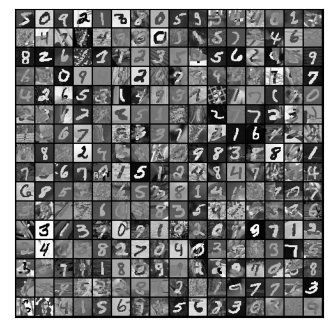

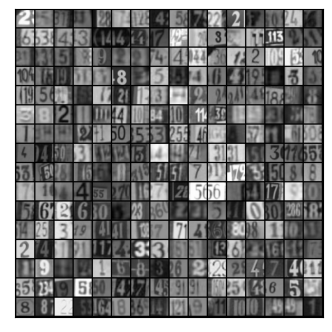

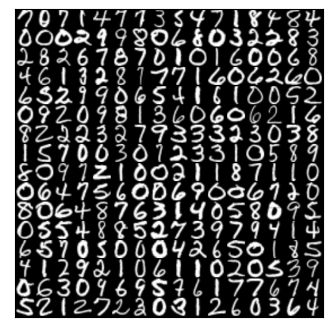

In [12]:
batchshow(testloaders['mnist'])
batchshow(testloaders['svhn'])
batchshow(testloaders['usps'])

# Models

In [13]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            # 1 x 28 x 28
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            torch.nn.Dropout2d(0.5),
            nn.MaxPool2d(2),
            # 16 x 14 x 14
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            torch.nn.Dropout2d(0.5),
            nn.MaxPool2d(2),
            # 32 x 7 x 7
            nn.Flatten(),
            # 
            nn.Linear(64 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.conv(x)

In [14]:
class LabelPredictor(nn.Module):
    def __init__(self):
        super(LabelPredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1024, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(50, 10),
        )
    
    def forward(self, x):
        return self.fc(x)

In [15]:
class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1024, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(50, 1),
        )
        
    def forward(self, x):
        return self.fc(x)

# Lower Bound & Upper Bound

In [16]:
class FE_LP(nn.Module):
    def __init__(self):
        super(FE_LP, self).__init__()
        self.fe = FeatureExtractor()
        self.lp = LabelPredictor()
    
    def forward(self, x):
        x = self.fe(x)
        x = self.lp(x)
        return x

In [17]:
m = FE_LP()
print(m)

FE_LP(
  (fe): FeatureExtractor(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout2d(p=0.5, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8): Dropout2d(p=0.5, inplace=False)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=3136, out_features=1024, bias=True)
      (12): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU()
    )
  )
  (lp): LabelPredictor(
    (fc): Sequential(
      (0): Linear(in_features=102

In [18]:
def train(model, optimizer, criterion, train_dl, test_dl, epochs, init_epoch=0, logfile='log.txt'):
    if init_epoch == 0:
        fout = open(logfile, 'w')
        fout.close()
        
    iter = 0    
    for epoch in range(epochs):
        model.train()
        for batch_idx, (x, y) in enumerate(train_dl):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            y_out = model(x) # feature_extractor + label_predictor
            # pred = y_out.max(1, keepdim=True)[1]
            loss = criterion(y_out, y)
            loss.backward()
            optimizer.step()

            iter += 1
            if iter % 60 == 0:
                fout = open(logfile, 'a')
                fout.write('Train Epoch: {} [{:5d}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                    epoch + init_epoch, 
                    batch_idx * len(x), 
                    len(train_dl.dataset),
                    100. * batch_idx / len(train_dl), 
                    loss.item()
                ))
                fout.close()

        train_acc = test(model, criterion, train_dl, 'train', logfile)
        mnist_acc = test(model, criterion, testloaders['mnist'], 'validation mnist', logfile)
        svhn_acc = test(model, criterion, testloaders['svhn'], 'validation svhn', logfile)
        usps_acc = test(model, criterion, testloaders['usps'], 'validation usps', logfile)

In [19]:
def test(model, criterion, test_dl, name, logfile='log.txt'):
    model.eval()
    
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_dl):
            x, y = x.to(device), y.to(device)
            y_out = model(x)
            total_loss += criterion(y_out, y).item()
            pred = y_out.max(1, keepdim=True)[1]
            correct += pred.eq(y.view_as(pred)).sum().item()

    total_loss /= len(test_dl.dataset)
    accuracy = 100.0 * correct / len(test_dl.dataset)

    fout = open(logfile, 'a')
    fout.write('{} set : Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        name,
        total_loss, 
        correct,
        len(test_dl.dataset),
        accuracy
    ))
    fout.close()

    return accuracy

In [20]:
# mnist_nn = FE_LP().to(device)
# # print(mnist_nn)
# optimizer = optim.Adam(mnist_nn.parameters())
# criterion = nn.CrossEntropyLoss()

In [21]:
# train(
#     model=mnist_nn, 
#     optimizer=optimizer, 
#     criterion=criterion,
#     train_dl=trainloaders['mnist'],
#     test_dl=testloaders['mnist'],
#     epochs=15,
#     logfile='./checkpoint/temp/train_mnist.txt',
# )
# save_checkpoint('./checkpoint/temp/train_mnist.pth', mnist_nn, optimizer)

In [22]:
# svhn_nn = FE_LP().to(device)
# # print(svhn_nn)
# optimizer = optim.Adam(svhn_nn.parameters())
# criterion = nn.CrossEntropyLoss()

In [23]:
# train(
#     model=svhn_nn, 
#     optimizer=optimizer, 
#     criterion=criterion,
#     train_dl=trainloaders['svhn'],
#     test_dl=testloaders['svhn'],
#     epochs=15,
#     logfile='./checkpoint/temp/train_svhn.txt',
# )
# save_checkpoint('./checkpoint/temp/train_svhn.pth', svhn_nn, optimizer)

In [24]:
# usps_nn = FE_LP().to(device)
# # print(usps_nn)
# optimizer = optim.Adam(usps_nn.parameters())
# criterion = nn.CrossEntropyLoss()

In [25]:
# train(
#     model=usps_nn, 
#     optimizer=optimizer, 
#     criterion=criterion,
#     train_dl=trainloaders['usps'],
#     test_dl=testloaders['usps'],
#     epochs=15,
#     logfile='./checkpoint/temp/train_usps.txt',
# )
# save_checkpoint('./checkpoint/temp/train_usps.pth', usps_nn, optimizer)

# DANN

In [26]:
def train_DANN(source_dl, target_dl, lamb):
    domain_classifier.train()
    feature_extractor.train()
    label_predictor.train()
    
    dc_loss, fe_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    for batch_idx, ((sx, sy), (tx, _)) in enumerate(zip(source_dl, target_dl)):

        sx, sy, tx = sx.to(device), sy.to(device), tx.to(device)
        optimizer_FE.zero_grad()
        optimizer_LP.zero_grad()
        optimizer_DC.zero_grad()

        # mix source/target data
        mix_x = torch.cat([sx, tx], dim=0)
        
        # domain labels
        domain_labels = torch.zeros([sx.shape[0] + tx.shape[0], 1]).to(device)
        domain_labels[:sx.shape[0]] = 1

        # train Domain Classifier
        features = feature_extractor(mix_x)
        domain_logits = domain_classifier(features.detach())
        loss = domain_criterion(domain_logits, domain_labels)
        dc_loss += loss.item()
        loss.backward()
        optimizer_DC.step()

        # train Feature Extractor and Label Predictor
        label_logits = label_predictor(features[:sx.shape[0]])
        domain_logits = domain_classifier(features)
        loss = label_criterion(label_logits, sy) - lamb * domain_criterion(domain_logits, domain_labels)
        fe_loss += loss.item()
        loss.backward()
        optimizer_FE.step()
        optimizer_LP.step()

        total_hit += torch.sum(torch.argmax(label_logits, dim=1) == sy).item()
        total_num += sx.shape[0]        
        
    return (dc_loss / (batch_idx + 1)), (fe_loss / (batch_idx + 1)), total_hit / total_num

In [27]:
def test_DANN(test_dl, name, logfile='log.txt'):
    feature_extractor.eval()
    label_predictor.eval()
    
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_dl):
            x, y = x.to(device), y.to(device)
            y_out = label_predictor(feature_extractor(x))
            total_loss += label_criterion(y_out, y).item()
            pred = y_out.max(1, keepdim=True)[1]
            correct += pred.eq(y.view_as(pred)).sum().item()

    total_loss /= len(test_dl.dataset)
    accuracy = 100.0 * correct / len(test_dl.dataset)

    fout = open(logfile, 'a')
    fout.write('{} set : Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        name,
        total_loss, 
        correct,
        len(test_dl.dataset),
        accuracy
    ))
    fout.close()

    return accuracy

In [28]:
# dann = FE_LP().to(device)
# optimizer = optim.Adam(dann.parameters())
# # load_checkpoint('./checkpoint/hw2p3/train_mnist.pth', dann, optimizer)
# # print(dann)
# feature_extractor = dann.fe.to(device)
# label_predictor = dann.lp.to(device)
# domain_classifier = DomainClassifier().to(device)
# # print(feature_extractor)
# # print(label_predictor)
# # print(domain_classifier)
# label_criterion = nn.CrossEntropyLoss()
# domain_criterion = nn.BCEWithLogitsLoss()

# optimizer_FE = optim.Adam(feature_extractor.parameters())
# optimizer_LP = optim.Adam(label_predictor.parameters())
# optimizer_DC = optim.Adam(domain_classifier.parameters())

In [29]:
# epochs = 30
# logfile = './checkpoint/temp/train_dann_usps.txt'
# fout = open(logfile, 'w')
# fout.close()

# best_acc = 0.0
# for epoch in range(epochs):
#     print('Epoch {}'.format(epoch))
#     dc_loss, fe_loss, train_acc = train_DANN(trainloaders['mnist'], trainloaders['usps'], lamb=0.1 * epoch)
#     fout = open(logfile, 'a')
#     fout.write('\nTrain Epoch: {} \tDomain Classifier Loss: {:.6f}\tFeature Extractor Loss: {:.6f}\tTrain Accuracy: {:.6f}\n'.format(
#         epoch, 
#         dc_loss,
#         fe_loss,
#         train_acc,
#     ))
#     fout.close()
#     test_acc = test_DANN(testloaders['usps'], 'usps', logfile)
#     if test_acc > best_acc:
#         best_acc = test_acc
#         save_checkpoint('./checkpoint/temp/pretrain_usps_dann_fe.pth', feature_extractor, optimizer_FE)
#         save_checkpoint('./checkpoint/temp/pretrain_usps_dann_lp.pth', label_predictor, optimizer_LP)
#         save_checkpoint('./checkpoint/temp/pretrain_usps_dann_dc.pth', domain_classifier, optimizer_DC)

In [30]:
# dann = FE_LP().to(device)
# optimizer = optim.Adam(dann.parameters())
# # load_checkpoint('./checkpoint/temp/train_mnist.pth', dann, optimizer)
# # print(dann)
# feature_extractor = dann.fe.to(device)
# label_predictor = dann.lp.to(device)
# domain_classifier = DomainClassifier().to(device)
# # print(feature_extractor)
# # print(label_predictor)
# # print(domain_classifier)
# label_criterion = nn.CrossEntropyLoss()
# domain_criterion = nn.BCEWithLogitsLoss()

# optimizer_FE = optim.Adam(feature_extractor.parameters())
# optimizer_LP = optim.Adam(label_predictor.parameters())
# optimizer_DC = optim.Adam(domain_classifier.parameters())

In [31]:
# epochs = 30
# logfile = './checkpoint/temp/train_dann_svhn.txt'
# fout = open(logfile, 'w')
# fout.close()

# best_acc = 0.0
# for epoch in range(epochs):
#     print('Epoch {}'.format(epoch))
#     dc_loss, fe_loss, train_acc = train_DANN(trainloaders['mnist'], trainloaders['svhn'], lamb=0.5)
#     fout = open(logfile, 'a')
#     fout.write('\nTrain Epoch: {} \tDomain Classifier Loss: {:.6f}\tFeature Extractor Loss: {:.6f}\tTrain Accuracy: {:.6f}\n'.format(
#         epoch, 
#         dc_loss,
#         fe_loss,
#         train_acc,
#     ))
#     fout.close()
#     test_acc = test_DANN(testloaders['svhn'], 'svhn', logfile)
#     if test_acc > best_acc:
#         best_acc = test_acc
#         save_checkpoint('./checkpoint/temp/dann_svhn_fe.pth', feature_extractor, optimizer_FE)
#         save_checkpoint('./checkpoint/temp/dann_svhn_lp.pth', label_predictor, optimizer_LP)
#         save_checkpoint('./checkpoint/temp/dann_svhn_dc.pth', domain_classifier, optimizer_DC)

# Inference

In [32]:
def validation(feature_extractor, label_predictor, test_dl):
    feature_extractor.eval()
    label_predictor.eval()
    
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_dl):
            x, y = x.to(device), y.to(device)
            y_out = label_predictor(feature_extractor(x))
            total_loss += label_criterion(y_out, y).item()
            pred = y_out.max(1, keepdim=True)[1]
            correct += pred.eq(y.view_as(pred)).sum().item()

    total_loss /= len(test_dl.dataset)
    accuracy = 100.0 * correct / len(test_dl.dataset)

    print('Validation set : Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        total_loss, 
        correct,
        len(test_dl.dataset),
        accuracy
    ))

    return accuracy

In [33]:
def scale_01(x):
    minn = np.min(x)
    maxn = np.max(x)
    return (x - minn) / (maxn - minn)

def scatterplot(tx, ty, all_labels, classes):
    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    colors = ['red', 'cyan', 'lime', 'blue', 'darkviolet', 'fuchsia', 'darkorange', 'sienna', 'dimgrey', 'yellow']

    # plot
    for label, color in zip(classes, colors):
        indices = [s for s, l in enumerate(all_labels) if l == label]
        ax.scatter(np.take(tx, indices), np.take(ty, indices), s=1, color=color, label=label)
    # ax.legend(loc='best')
    plt.show()

def scatterplot2(tx, ty, all_labels):
    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    colors = ['red', 'cyan']

    # plot
    indices_0 = [s for s, l in enumerate(all_labels) if l == 0]
    indices_1 = [s for s, l in enumerate(all_labels) if l == 1]

    half_0 = int(len(indices_0) / 2)
    half_1 = int(len(indices_1) / 2)
    ax.scatter(np.take(tx, indices_0[:half_0]), np.take(ty, indices_0[:half_0]), s=1, color='red', label=0)
    ax.scatter(np.take(tx, indices_1), np.take(ty, indices_1), s=1, color='cyan', label=1)
    ax.scatter(np.take(tx, indices_0[half_0:]), np.take(ty, indices_0[half_0:]), s=1, color='red', label=0)
    # ax.legend(loc='best')
    plt.show()

def tSNEshow(feature_extractor, source_dl, target_dl):
    feature_extractor.eval()
    features = None
    all_labels = []
    all_domains = []

    # source domain
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(source_dl):
            x, y = x.to(device), y.to(device)
            feat_out = (feature_extractor(x))
            all_labels.extend(y)
            all_domains.extend([1] *  len(x))
            if features is None:
                features = feat_out.cpu().numpy()
            else:
                features = np.concatenate((features, feat_out.cpu().numpy()))

    # target domain
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(source_dl):
            x, y = x.to(device), y.to(device)
            feat_out = (feature_extractor(x))
            all_labels.extend(y)
            all_domains.extend([0] *  len(x))
            if features is None:
                features = feat_out.cpu().numpy()
            else:
                features = np.concatenate((features, feat_out.cpu().numpy()))
    

    # tsne
    func = TSNE(n_components=2, init='pca', learning_rate='auto')
    tsne = func.fit_transform(features)
    tx = scale_01(tsne[:, 0])
    ty = scale_01(tsne[:, 1])

    # plot
    scatterplot(tx, ty, all_labels, [i for i in range(10)])    
    scatterplot2(tx, ty, all_domains)    

In [34]:
feature_extractor = FeatureExtractor().to(device)
label_predictor = LabelPredictor().to(device)
domain_classifier = DomainClassifier().to(device)

optimizer_FE = optim.Adam(feature_extractor.parameters())
optimizer_LP = optim.Adam(label_predictor.parameters())
optimizer_DC = optim.Adam(domain_classifier.parameters())

load_checkpoint('./checkpoint/hw2p3/dann_svhn_fe.pth', feature_extractor, optimizer_FE)
load_checkpoint('./checkpoint/hw2p3/dann_svhn_lp.pth', label_predictor, optimizer_LP)
load_checkpoint('./checkpoint/hw2p3/dann_svhn_dc.pth', domain_classifier, optimizer_DC)

label_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

model loaded from ./checkpoint/temp/dann_svhn_fe.pth 
model loaded from ./checkpoint/temp/dann_svhn_lp.pth 
model loaded from ./checkpoint/temp/dann_svhn_dc.pth 


In [35]:
print(feature_extractor)

FeatureExtractor(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.5, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=3136, out_features=1024, bias=True)
    (12): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
  )
)


In [36]:
print(label_predictor)

LabelPredictor(
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [37]:
print(domain_classifier)

DomainClassifier(
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [38]:
test_acc = validation(feature_extractor, label_predictor, testloaders['svhn'])

Validation set : Average loss: 0.0069, Accuracy: 6666/15887 (41.9588%)



/nfs/home/mirkat/anaconda3/envs/dlcv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


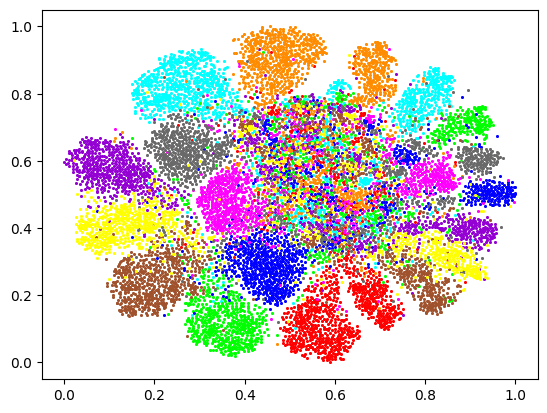

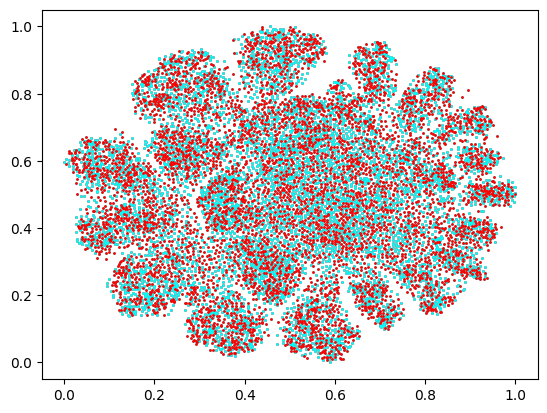

In [39]:
tSNEshow(feature_extractor, testloaders['mnist'], testloaders['svhn'])

In [40]:
feature_extractor = FeatureExtractor().to(device)
label_predictor = LabelPredictor().to(device)
domain_classifier = DomainClassifier().to(device)

optimizer_FE = optim.Adam(feature_extractor.parameters())
optimizer_LP = optim.Adam(label_predictor.parameters())
optimizer_DC = optim.Adam(domain_classifier.parameters())

load_checkpoint('./checkpoint/hw2p3/dann_usps_fe.pth', feature_extractor, optimizer_FE)
load_checkpoint('./checkpoint/hw2p3/dann_usps_lp.pth', label_predictor, optimizer_LP)
load_checkpoint('./checkpoint/hw2p3/dann_usps_dc.pth', domain_classifier, optimizer_DC)

label_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

model loaded from ./checkpoint/hw2p3/dann_usps_fe.pth 
model loaded from ./checkpoint/hw2p3/dann_usps_lp.pth 
model loaded from ./checkpoint/hw2p3/dann_usps_dc.pth 


In [41]:
test_acc = validation(feature_extractor, label_predictor, testloaders['usps'])

Validation set : Average loss: 0.0035, Accuracy: 1134/1488 (76.2097%)



/nfs/home/mirkat/anaconda3/envs/dlcv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


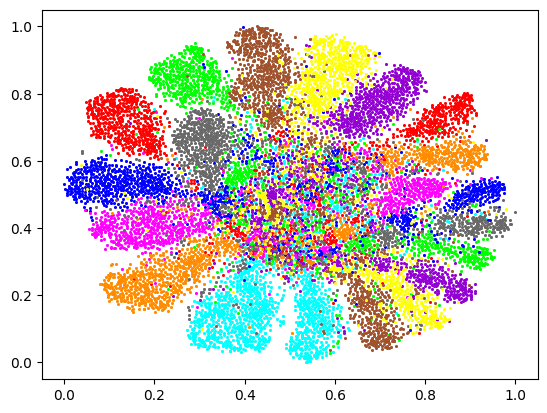

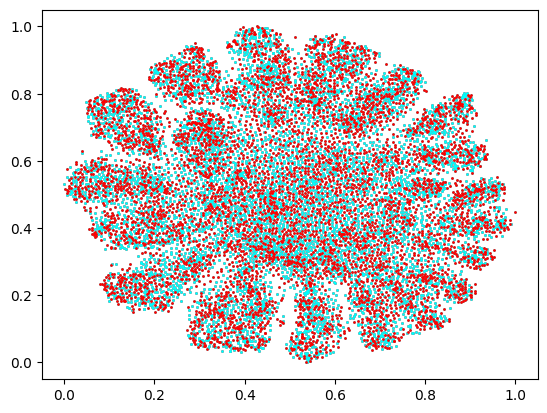

In [42]:
tSNEshow(feature_extractor, testloaders['mnist'], testloaders['usps'])